#  Synthetic Feasibility

- Often molecules that are enumerated are very difficult to make 
 - and thus not worth inspection, even if their other chemical properties are good in silico.  
- This tutorial goes through how to train the [ScScore](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00622) model [1].
 - Synthetic Complexity Learned from a Reaction Corpus
 - The idea of the model is to train on pairs of molecules where one molecule is "more complex" than the other.  
 - The neural network then can make scores which attempt to keep this pairwise ordering of molecules.  
 - The final result is a model which can give a relative complexity of a molecule.

- The paper trains on every reaction in reaxys, declaring products more complex than reactions.  
 - Since this training set is prohibitively expensive we will instead train on arbitrary molecules declaring one more complex if its SMILES string is longer.  
 - In the real world you can use whatever measure of complexity makes sense for the project.

- We'll use the Tox21 dataset to train our simple synthetic feasibility model.


# import

In [1]:
!pip install --pre deepchem
import deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 7.8 MB/s 
     |████████████████████████████████| 36.8 MB 37 kB/s 


In [16]:
import deepchem as dc
from rdkit import Chem
import random
from deepchem.feat import CircularFingerprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Datasets

- We load Tox21, specifying `splitter=None` so everything will be returned as a single dataset.

In [2]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='Raw', splitter=None)
molecules = datasets[0].X

- Because ScScore is trained on relative complexities, we want the `X` tensor in our dataset to have 3 dimensions `(sample_id, molecule_id, features)`.  
- The `molecule_id` dimension has size 2 because a sample is a pair of molecules.  
- The label is 1 if the first molecule is more complex than the second molecule. 
- The function `create_dataset` we introduce below pulls random pairs of SMILES strings out of a given list and ranks them according to this complexity measure.

- In the real world you could use purchase cost, or number of reaction steps required as your complexity score. 

In [12]:
def create_dataset(fingerprints, smiles_lens, ds_size=100000):
    """
    m1: list of np.Array
        fingerprints for molecules
    m2: list of int
        length of a molecules SMILES string
    
    returns:
        dc.data.Dataset for input into ScScore Model
        
    Dataset.X
        shape is (sample_id, molecule_id, features)
    Dataset.y
        shape is (sample_id,)
        values is 1 if the 0th index molecule is more complex
                  0 if the 1st index molecule is more complex
    """
    X, y = [], []
    all_data = list(zip(fingerprints, smiles_lens))
    while len(y) < ds_size:
        i1 = random.randrange(0, len(smiles_lens))
        i2 = random.randrange(0, len(smiles_lens))
        m1 = all_data[i1]
        m2 = all_data[i2]
        if m1[1] == m2[1]:
            continue
        if m1[1] > m2[1]:
            y.append(1.0)
        else:
            y.append(0.0)
        X.append([m1[0], m2[0]])
    return dc.data.NumpyDataset(np.array(X), np.expand_dims(np.array(y), axis=1))

With our complexity ranker in place we can now construct our dataset. Let's start by randomly splitting the list of molecules into training and test sets.

In [13]:
molecule_ds = dc.data.NumpyDataset(np.array(molecules))
splitter = dc.splits.RandomSplitter()
train_mols, test_mols = splitter.train_test_split(molecule_ds)

We'll featurize all our molecules with the ECFP fingerprint with chirality (matching the source paper), and will then construct our pairwise dataset using the function defined above.

In [14]:
n_features = 1024
featurizer = dc.feat.CircularFingerprint(size=n_features, radius=2, chiral=True)
train_features = featurizer.featurize(train_mols.X)
train_smiles_len = [len(Chem.MolToSmiles(x)) for x in train_mols.X]
train_dataset = create_dataset(train_features, train_smiles_len)

# Train Model

Now that we have our dataset created, let's train a `ScScoreModel` on this dataset.

In [15]:
model = dc.models.ScScoreModel(n_features=n_features)
model.fit(train_dataset, nb_epoch=20)

0.04178923606872559

# Model Evaluate

Lets evaluate how well the model does on our holdout molecules.  The SaScores should track the length of SMILES strings from never before seen molecules.

In [17]:
mol_scores = model.predict_mols(test_mols.X)
smiles_lengths = [len(Chem.MolToSmiles(x)) for x in test_mols.X]

Let's now plot the length of the smiles string of the molecule against the SaScore

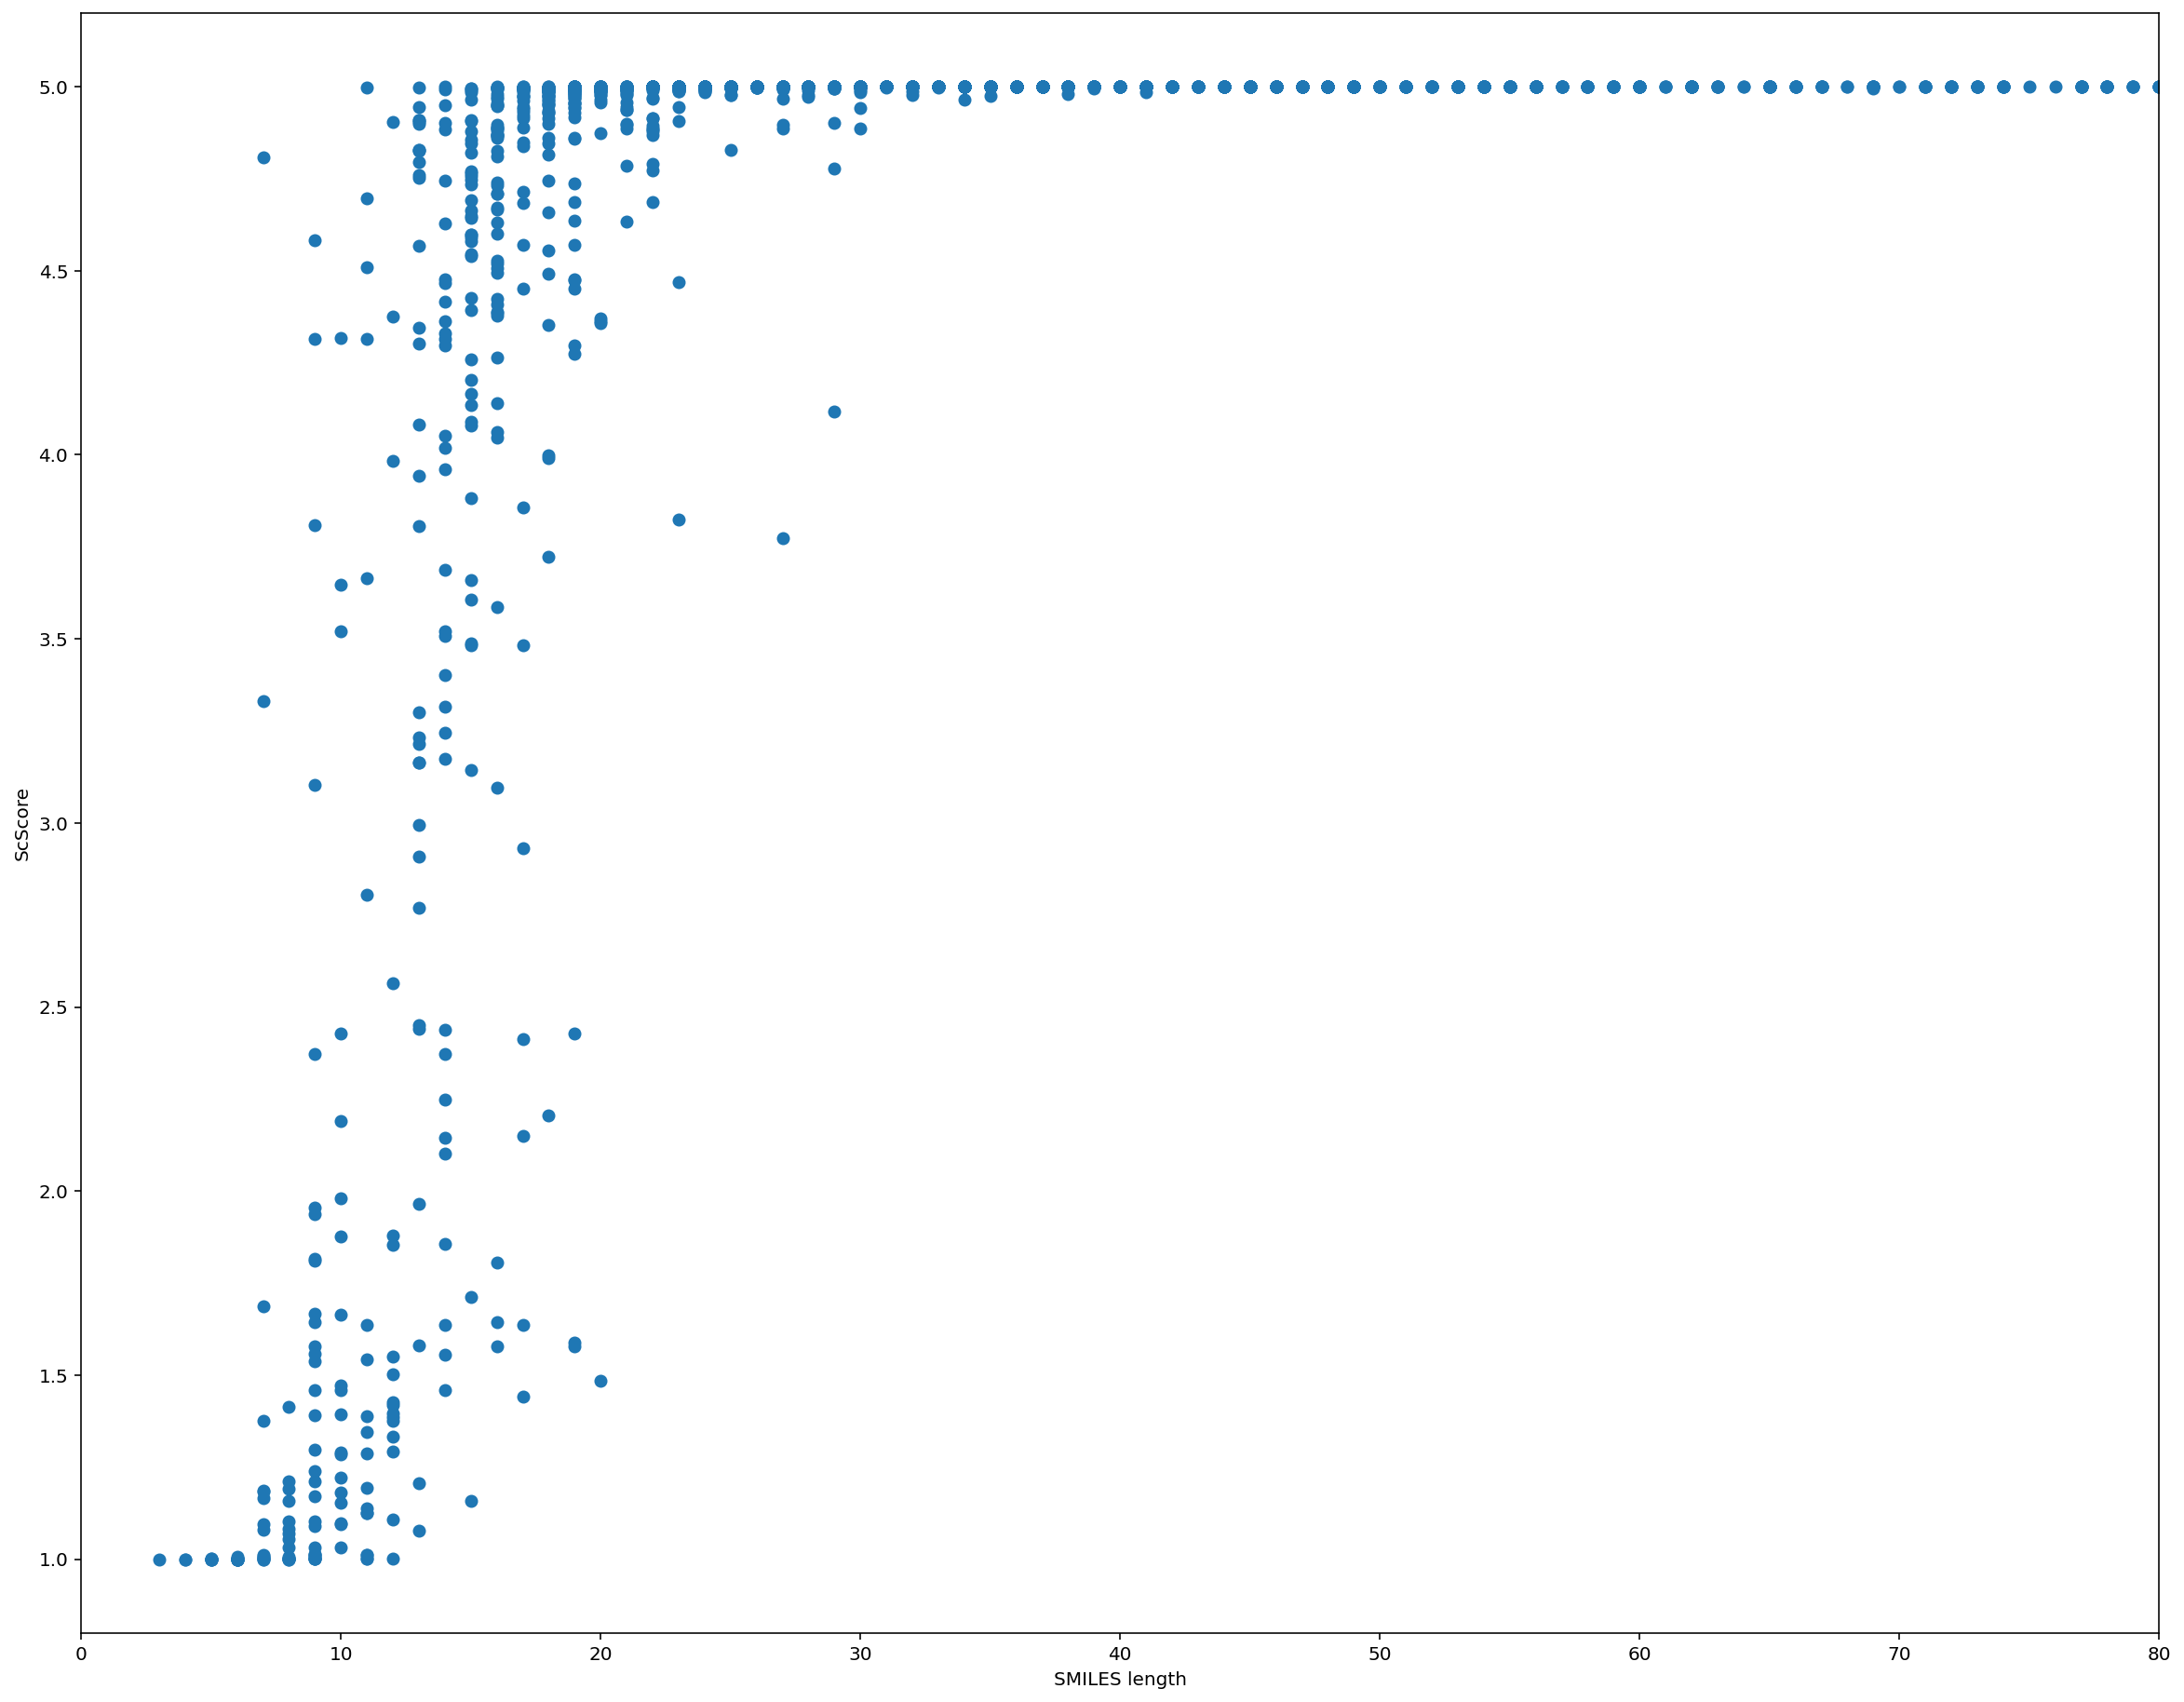

In [19]:
plt.figure(figsize=(20,16))
plt.scatter(smiles_lengths, mol_scores)
plt.xlim(0,80)
plt.xlabel("SMILES length")
plt.ylabel("ScScore")
plt.show()

As we can see the model generally tracks SMILES length.  It has good enrichment between 8 and 30 characters and gets both small and large SMILES strings extremes dead on.

Now you can train your own models on more meaningful metrics than SMILES length!